In [1]:
import numpy as np
import os
import pandas as pd

In [2]:
labels = pd.read_csv("HASYv2/hasy-data-labels.csv")

In [3]:
include = np.arange(70, 80, 1)

y = labels.loc[labels['symbol_id'].isin(include)]


In [4]:
# Check numbers of examples
y.shape

(1020, 4)

In [8]:
from scipy.misc import imread

# Read the specified images as flat vectors
samples = []
for filename in y["path"]:
    img = imread("HASYv2/"+filename, mode='L').reshape(-1)
    samples.append(img)

X = pd.DataFrame.from_records(samples).as_matrix()
# Check dims
X.shape

(1020, 1024)

In [9]:
# Split into train and test and take only labels from y

from sklearn.utils import shuffle
X, y = shuffle(X, y)

X_train = X[:int(X.shape[0] * 0.8), :]
y_train = y["symbol_id"].as_matrix()[:int(y.shape[0] * 0.8)]

X_test = X[int(X.shape[0] * 0.8):, :]
y_test = y["symbol_id"].as_matrix()[int(y.shape[0] * 0.8):]

# Confirm shapes
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(816, 1024) (816,) (204, 1024) (204,)


In [10]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [11]:
# Evaluate on test set
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, lr.predict(X_test)))

0.877450980392


In [12]:
# Naive classifier
from scipy import stats


def naive_classify(y_train, X_test):
    most_common = int(stats.mode(y_train).mode[0])
    return np.ones(X_test.shape[0]) * most_common

print(accuracy_score(y_test, naive_classify(y_train, X_test)))

0.107843137255


### This time train a random forest classifier on the data. A random forest is a collection of decision trees, which makes it an ensemble of classifiers. Each tree uses a random subset of the features to make it's prediction. Without tuning any parameters, how is the accuracy?

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

print(accuracy_score(y_test, rf.predict(X_test)))

0.745098039216


### The amount of trees to use as a part of the random forest is an example of a hyperparameter, because it is a parameter that is set prior to the learning process. In contrast, a parameter is a value in the model that is learned from the data. Train 20 classifiers, with varying amounts of decision trees starting from 10 up until 200, and plot the test accuracy as a function of the amount of classifiers. Does the accuracy keep increasing? Is more better?

Clearly more is not better, but the accuracy is more or less the same

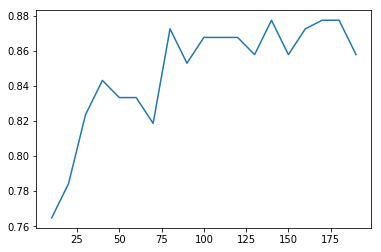

In [15]:
from sklearn.ensemble import RandomForestClassifier

accs = []
trees = np.arange(10, 200, 10)
for i in trees:
    rf = RandomForestClassifier(n_estimators=i)
    rf.fit(X_train, y_train)

    acc = accuracy_score(y_test, rf.predict(X_test))
    accs.append(acc)

import matplotlib.pyplot as plt

plt.plot(trees, accs)
plt.show()

### If we had picked the amount of decision trees by taking the value with the best test accuracy from the last plot, we would have overfit our hyperparameters to the test data. Can you see why it is a mistake to tune hyperparameters of your model by using the test data?

Finding the optimal parameters for your test data simply overfits to it, and since we are interested in how well the model generalizes, this is a bad thing.

### Reshuffle and resplit the data so that it is divided in 3 parts: training (80%), validation (10%) and test (10%). Repeatedly train a model of your choosing (e.g random forest) on the training data, and evaluate it's performance on the validation set, while tuning the hyperparameters so that the accuracy on the validation set increases. Then, finally evaluate the performance of your model on the test data. What can you say in terms of the generalization of your model?

In [16]:
from sklearn.utils import shuffle
X, y = shuffle(X, y)

train_part = int(X.shape[0] * 0.8)
val_part = int(X.shape[0] * 0.1)

X_train = X[:train_part, :]
y_train = y["symbol_id"].as_matrix()[:train_part]

X_val = X[train_part: train_part + val_part, :]
y_val = y["symbol_id"].as_matrix()[train_part: train_part + val_part:]

X_test = X[train_part + val_part:, :]
y_test = y["symbol_id"].as_matrix()[train_part + val_part:]

# Confirm shapes
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(816, 1024) (816,) (102, 1024) (102,) (102, 1024) (102,)


In [20]:
sizes = np.arange(100, 1000, 100)
val_accs = np.zeros(len(sizes))
classifiers = []

for idx, size in enumerate(sizes):
    rf = RandomForestClassifier(n_estimators=size)
    rf.fit(X_train, y_train)

    acc = accuracy_score(y_val, rf.predict(X_val))
    val_accs[idx] = acc
    classifiers.append(rf)

print("best val acc", sizes[np.argmax(val_accs)])

best val acc 600


In [21]:
# Evaluate best classifier on test set
# Accuracy is much better than without tuning

best = classifiers[np.argmax(val_accs)]

print(accuracy_score(y_test, best.predict(X_test)))

0.872549019608


### This process of picking a suitable model, evaluating it's performance and tuning the hyperparameters is very time consuming. A new idea in machine learning is the concept of automating this by using an optimization algorithm to find the best model in the space of models and their hyperparameters. Have a look at TPOT, an automated ML solution that finds a good model and a good set of hyperparameters automatically. Try it on this data, it should outperform simple models like the ones we tried easily. Note that running the algorithm might take a while, depending on the strength of your computer. TPOT uses cross-validation internally, so we don't need our own validation set.

TPOT does the tuning for us, trying out different models and different hyperparameters. 

In [22]:
from tpot import TPOTClassifier
tpot = TPOTClassifier(generations=3, population_size=3, verbosity=2, max_eval_time_mins=1)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

Version 0.8.3 of tpot is outdated. Version 0.9.0 was released 3 days ago.


Optimization Progress:  50%|█████     | 6/12 [00:24<00:46,  7.68s/pipeline]

Generation 1 - Current best internal CV score: 0.8011768383848363


Optimization Progress:  75%|███████▌  | 9/12 [00:40<00:25,  8.62s/pipeline]

Generation 2 - Current best internal CV score: 0.8011768383848363


Generation 3 - Current best internal CV score: 0.8011768383848363

Best pipeline: ExtraTreesClassifier(input_matrix, ExtraTreesClassifier__bootstrap=False, ExtraTreesClassifier__criterion=gini, ExtraTreesClassifier__max_features=0.1, ExtraTreesClassifier__min_samples_leaf=3, ExtraTreesClassifier__min_samples_split=13, ExtraTreesClassifier__n_estimators=100)
0.852941176471
